# Project Report Group 33


### Predicting a Tennis Player's Best Rank Based on Their Age, Seasons Played, Current Rank, and Prize Money

### Introduction


Tennis is a popular individual sport with a history of competitive tournaments and rankings. Tennis player rankings are essential to evaluate their performance but predicting a player's best rank can be difficult. This project analyzes the players statistics of the top 500 tennis players worldwide. We used K-nearest neighbor regression to see how accurately we can predict a player's Best Rank based on Age, Seasons Played, Current Rank, and Prize Money. The dataset is analyzed using five-fold cross-validation, and visualization techniques such as scatter plots provides insight into factors that influence ranking. Our findings are beneficial for players as it would allow them to visualize their athletic career and potential better and what factors will have the greatest impact.

### Preliminary Data Analysis


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(knitr)
library(tibble)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

The seed value is set to 4321 in every coding cell to ensure that every random process yields the same outcome when the code reruns. We initially set the seed only in the beginning of the notebook (cell 2), but some of our randomized values yieled different results when run multiple times. 

In [2]:
set.seed(4321)

In [3]:
set.seed(4321)
url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
tennis_data <- read_csv(url)
print("Tibble 1.1: The Tennis dataset before any wrangling")
head(tennis_data, n=10)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Tibble 1.1: The Tennis dataset before any wrangling"


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,28 (18-11-1991),United States,Right-handed,Wikipedia,307 (131),213 (31-10-2016),Sekou Bangoura,Two-handed,"$278,709",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,21 (12-05-1998),"Taiwan, Province of China",Right-handed,Wikipedia,232 (205),229 (04-11-2019),Tung Lin Wu,Two-handed,"$59,123",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,25 (29-07-1994),Uzbekistan,Right-handed,Wikipedia,417 (81),253 (17-07-2017),Sanjar Fayziev,Two-handed,"$122,734",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


For our project we chose the columns Age, Best Rank, Prize Money, Current Rank, and Seasons. These predictors were selected because they contain the most data compared to other columns which mostly contain N/As and all these variables have a direct or indirect impact on a player's performance.

We also isolated our desired variables, deleted empty observations, and removed unnecessary characters such as the unnecessary strings in the Prize Money varaible.

In [4]:
set.seed(4321)
colnames(tennis_data) <- make.names(colnames(tennis_data))
tennis_data_separated <- tennis_data |> select(Age, Best.Rank, Prize.Money, Seasons, Current.Rank) |>
                separate(col = Age,
                        into = c("Age", "date"),
                        sep=" ",
                        convert=TRUE) |>
                separate(col = Best.Rank,
                        into = c("best_rank", "date_rank"),
                        sep=" ",
                        convert=TRUE) |>

                separate(col = Current.Rank,
                        into = c("current_rank", "date_cur_rank"),
                        sep=" ",
                        convert=TRUE) |>
    select(Age, best_rank, current_rank, Prize.Money, Seasons)


print("Tibble 1.2: The Tennis dataset after some data wrangling")
head(tennis_data_separated, n = 10)


[1] "Tibble 1.2: The Tennis dataset after some data wrangling"


Age,best_rank,current_rank,Prize.Money,Seasons
<int>,<int>,<int>,<chr>,<dbl>
26,363,378,NA,NA
18,316,326,"$59,040",NA
32,44,178,"US$3,261,567",14
21,130,236,"$374,093",2
27,17,183,"US$6,091,971",11
22,31,31,"$1,517,157",5
28,213,307,"$278,709",1
21,229,232,"$59,123",1
25,253,417,"$122,734",5


In [5]:
set.seed(4321)
tennis_data_separated$Prize.Money <- gsub("US", " ", tennis_data_separated$Prize.Money)


tennis_data_separated$Prize.Money <- gsub("US", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("all-time leader in earnings", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("11th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("24th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("10th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("14th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("27th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("15th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("30th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("All-time leader in earnings", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("4th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("28th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("2nd", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("6th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("33rd", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("26th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("24th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("48th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("41st", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("\\$","", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub(" ", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("   ", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("  ", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub(" all-time in earnings", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub(",", "", tennis_data_separated$Prize.Money)

tennis_data_renamed <- tennis_data_separated |>
    rename("Best_Rank" = "best_rank") |>
    rename("Current_Rank" = "current_rank")

print("Tibble 1.3: The Tennis dataset after more data wrangling")
head(tennis_data_renamed, n = 10)

[1] "Tibble 1.3: The Tennis dataset after more data wrangling"


Age,Best_Rank,Current_Rank,Prize.Money,Seasons
<int>,<int>,<int>,<chr>,<dbl>
26,363,378,NA,NA
18,316,326,59040,NA
32,44,178,3261567,14
21,130,236,374093,2
27,17,183,6091971,11
22,31,31,1517157,5
28,213,307,278709,1
21,229,232,59123,1
25,253,417,122734,5


We also converted the Prize Money column from character into double.

In [6]:
set.seed(4321)
tennis_data_mutated <- tennis_data_renamed |>
    mutate(Prize_Money = as.numeric(Prize.Money)) |>
    na.omit() |>
    select(Age, Best_Rank, Current_Rank, Prize_Money, Seasons)

print("Tibble 1.4: The Tennis dataset after some conversions")
head(tennis_data_mutated, n = 10)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


[1] "Tibble 1.4: The Tennis dataset after some conversions"


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<int>,<int>,<int>,<dbl>,<dbl>
32,44,178,3261567,14
21,130,236,374093,2
27,17,183,6091971,11
22,31,31,1517157,5
28,213,307,278709,1
21,229,232,59123,1
25,253,417,122734,5
20,104,104,74927,3
19,17,22,1893476,3


We split the data into 75% training and 25% testing datasets with starta set to  our target variable (Best_Rank). We will use the training set to train the model and the testing set to assess its accuracy. 

In [7]:
set.seed(4321)
tennis_data_split <- initial_split(tennis_data_mutated, prop = .75, strata = Best_Rank)
tennis_data_train <- training(tennis_data_split)
tennis_data_test <- testing(tennis_data_split)

print("Tibble 1.5: The Tennis training dataset")
head(tennis_data_train, n = 10)
print("Tibble 1.5: The Tennis testing dataset")
head(tennis_data_test, n = 10)

[1] "Tibble 1.5: The Tennis training dataset"


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<int>,<int>,<int>,<dbl>,<dbl>
27,17,183,6091971,11
22,31,31,1517157,5
19,17,22,1893476,3
23,4,4,10507693,5
31,3,121,25889586,14
22,25,34,2722314,6
33,19,130,10821168,14
32,11,45,11912152,15
32,9,12,13470614,16


[1] "Tibble 1.5: The Tennis testing dataset"


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<int>,<int>,<int>,<dbl>,<dbl>
21,130,236,374093,2
25,253,417,122734,5
22,238,432,62529,1
35,18,85,10581476,18
27,11,14,7217264,8
27,26,41,3062847,11
26,99,99,709278,7
22,335,440,89281,1
33,1,1,119601561,19


In [8]:
set.seed(4321)
tennis_data_train_mean <- tennis_data_train |> map_df(mean) 
tennis_data_train_median <- tennis_data_train |> map_df(median)

print("Table 1.1: Training Tennis Data Mean")
tennis_data_train_mean
print("Table 1.2: Training Tennis Data Median")
tennis_data_train_median

[1] "Table 1.1: Training Tennis Data Mean"


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
27.0625,127.7684,207.9154,3861066,6.713235


[1] "Table 1.2: Training Tennis Data Median"


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
27,99,196.5,645079,5


The tables above show that the data needs to be standardized since our predictors have very different ranges and we do not want the predictors with larger scales (such as Prize Money) to have a greater effect on our model than the ones with smaller scales (such as Seasons). We can also observe that Prize Money has a much larger mean value compared to its median value which could point to potential outliers that are boosting the average and skewing the distribution which again suggests we should standardize our data.


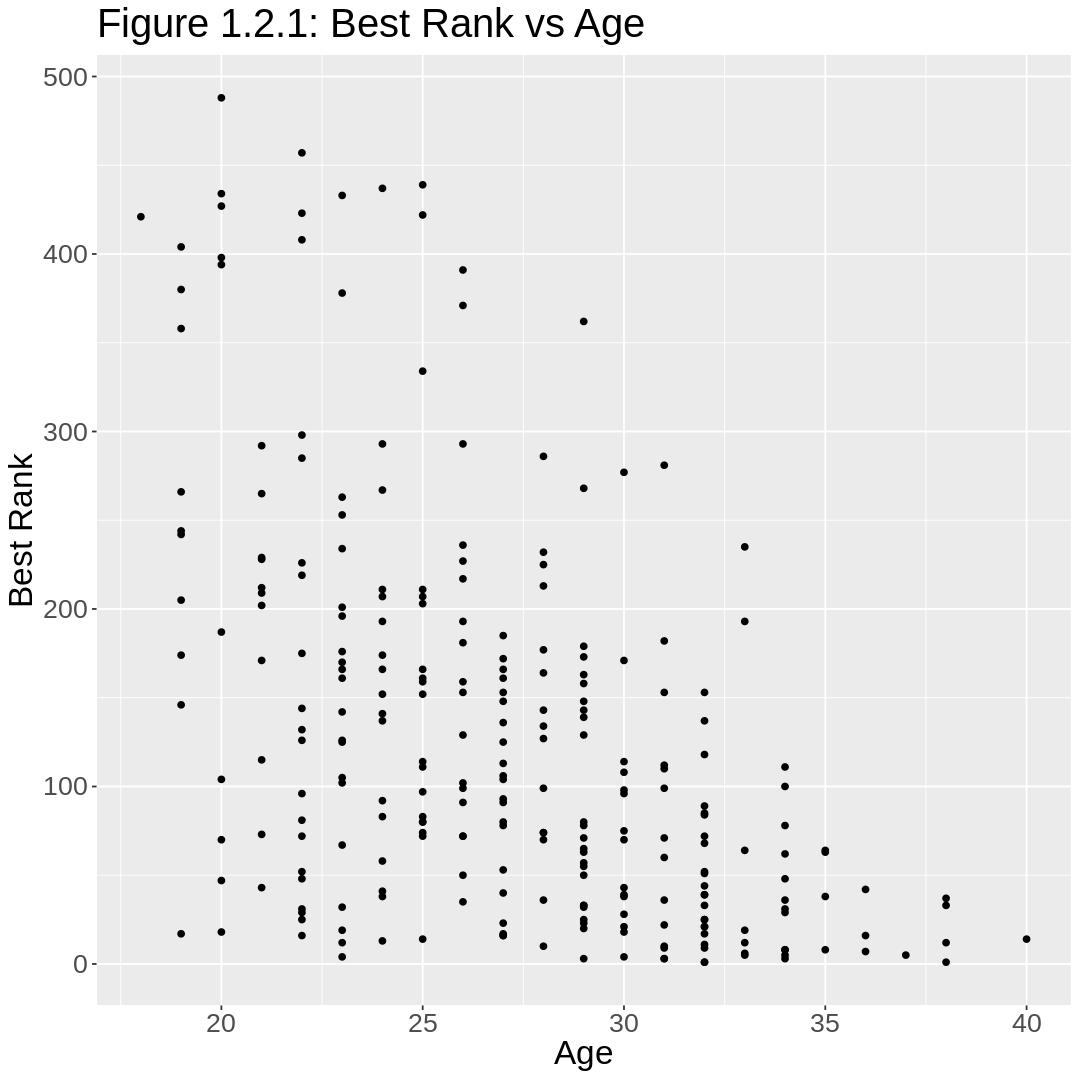

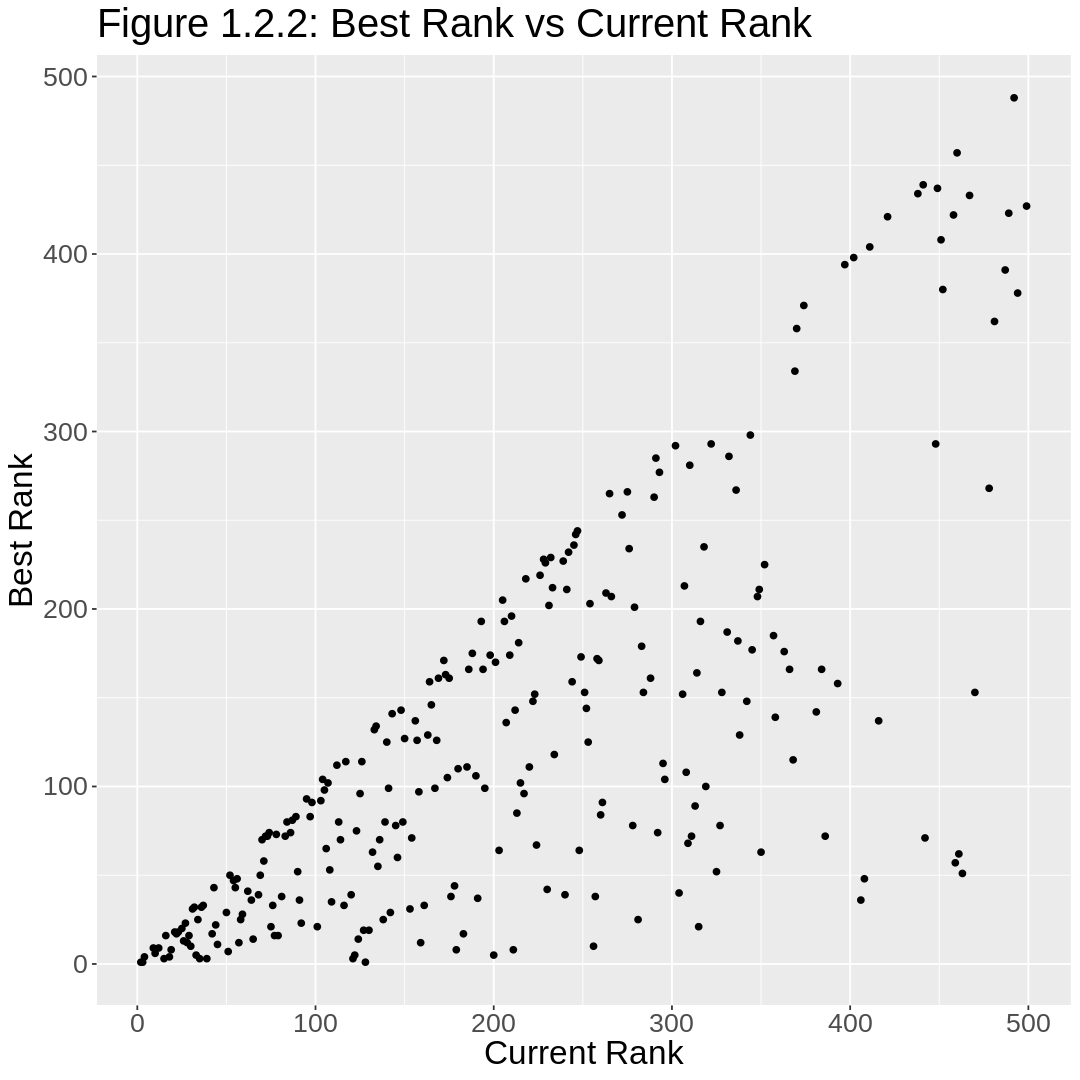

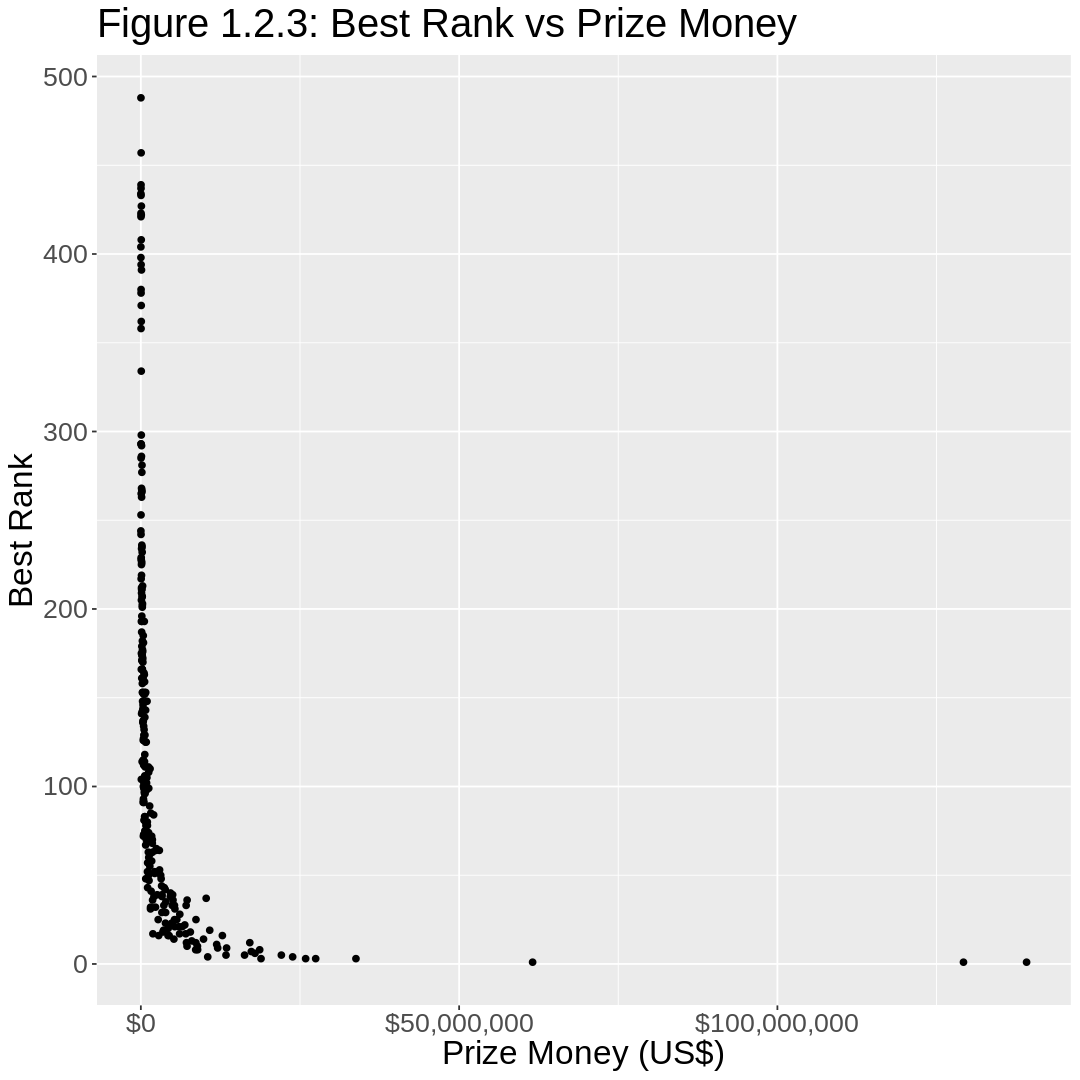

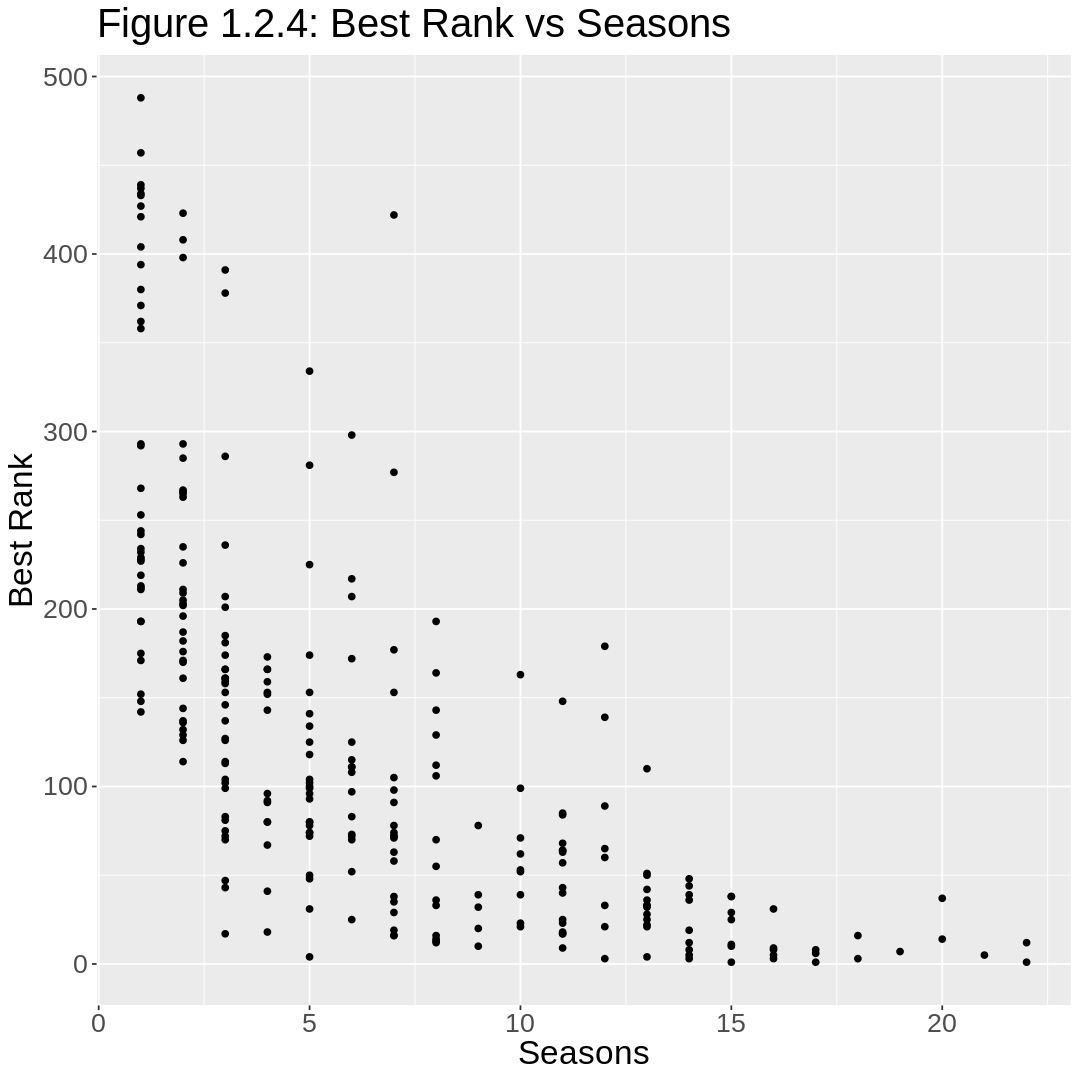

In [9]:
set.seed(4321)
options(repr.plot.width = 9, repr.plot.height = 9)
ggplot(tennis_data_train, aes(x = Age, y = Best_Rank)) +
    geom_point() +
    labs(title = "Figure 1.2.1: Best Rank vs Age", x = "Age", y = "Best Rank") +
    theme(text = element_text(size = 20))

ggplot(tennis_data_train, aes(x = Current_Rank, y = Best_Rank)) +
    geom_point() +
    labs(title = "Figure 1.2.2: Best Rank vs Current Rank", x = "Current Rank", y = "Best Rank") +
    theme(text = element_text(size = 20))

ggplot(tennis_data_train, aes(x = Prize_Money, y = Best_Rank)) +
    geom_point() +
    labs(title = "Figure 1.2.3: Best Rank vs Prize Money", x = "Prize Money (US$)", y = "Best Rank") +
    scale_x_continuous(labels = dollar_format()) +
    theme(text = element_text(size = 20))

ggplot(tennis_data_train, aes(x = Seasons, y = Best_Rank)) +
    geom_point() +
    labs(title = "Figure 1.2.4: Best Rank vs Seasons", x = "Seasons", y = "Best Rank") +
    theme(text = element_text(size = 20))

As seen from the plots above, Age and Best Rank have a weak negative linear relationship which suggests that statistically, age has an impact on a player's best rank, which is why we chose this predictor. Furthermore, Best Rank and Current Rank have a strong positive linear relationship which indicates that a player's Current Rank influences their projected Best Rank. We also noted that Current Rank can never be numerically lower than the Best Rank. Moreover, Best Rank and Prize Money have a negative exponential relationship, meaning that only the highest ranking players are winning extremely large sums; as a player's rank decreases as their winnings increase. There is also a weak exponential decay relationship between Best Rank and Seasons which indicates that the more seasons a player has played, the more likely they are to have a lower rank. All of these variables have a distinct influence on the Best Rank which is why we chose as our predictors in our model.

### Methods

Since we need to standardize the data before any further analysis, we will begin by making a recipe that contains all predictor variables (tennis_data_recipe) as well as four other recipes for each of the predictors individually. Each recipe will scale and center all the predictors in the model.  

In [10]:
set.seed(4321)
tennis_data_recipe <- recipe(Best_Rank ~ Age + Current_Rank + Prize_Money + Seasons, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

tennis_data_recipe_age <- recipe(Best_Rank ~ Age, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

tennis_data_recipe_cr <- recipe(Best_Rank ~ Current_Rank, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

tennis_data_recipe_pm <- recipe(Best_Rank ~ Prize_Money + Seasons, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

tennis_data_recipe_seasons <- recipe(Best_Rank ~ Seasons, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

Next we created our KNN regression model, the neighbors were set to tune() to find the optimal value of k.

In [11]:

set.seed(4321)
tennis_data_specs <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")
tennis_data_specs

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### Model 1: Age as the only predictor

Next we made the workflow for the model using the `tennis_data_specs` and `tennis_data_recipe_age` which  only used age as the predictor variable.

In [12]:
set.seed(4321)
tennis_data_workflow_age <- workflow() |>
    add_recipe(tennis_data_recipe_age) |>
    add_model(tennis_data_specs)

tennis_data_workflow_age

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In order to find the optimal value for k for this model, we used a five fold cross validation with parameter values from 1 to 100 skipping every other number.

In [13]:
set.seed(4321)

tennis_data_vfold <- vfold_cv(tennis_data_train, v = 5, strata = Best_Rank)

gridvals <- tibble <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

age_result <- tennis_data_workflow_age |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

print("Tibble 1.2.5: Age model cross validation results")
head(age_result, n= 10)

[1] "Tibble 1.2.5: Age model cross validation results"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,143.71803,5,4.030194,Preprocessor1_Model01
3,rmse,standard,128.55405,5,2.881822,Preprocessor1_Model02
5,rmse,standard,122.10647,5,2.162350,Preprocessor1_Model03
7,rmse,standard,113.69001,5,2.039605,Preprocessor1_Model04
9,rmse,standard,106.29080,5,1.934944,Preprocessor1_Model05
11,rmse,standard,103.70256,5,2.354279,Preprocessor1_Model06
13,rmse,standard,101.60395,5,1.379246,Preprocessor1_Model07
15,rmse,standard,101.04492,5,1.596411,Preprocessor1_Model08
17,rmse,standard,98.86195,5,1.293374,Preprocessor1_Model09


Next we selected the number of neighbors that coincides with the lowest estimate RMSE since we wanted to get the lowest RMSPE.

In [14]:
set.seed(4321)

kmin_age_df <- age_result |>
    filter(mean == min(mean))

kmin_age <- kmin_age_df |>
    pull(neighbors)

print("Tibble 1.2.6: Age model cross validation results with only the lowest RMSE row")
kmin_age_df
kmin_age

[1] "Tibble 1.2.6: Age model cross validation results with only the lowest RMSE row"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,rmse,standard,96.50037,5,1.605605,Preprocessor1_Model13


[1] 25

We used k = 25 for our knn regression model and evaluated it using the testing data.

In [15]:
set.seed(4321)

tennis_data_specs_age <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_age) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit_age <- workflow() |>
    add_recipe(tennis_data_recipe_age) |>
    add_model(tennis_data_specs_age) |>
    fit(data = tennis_data_train)

age_pred <- tennis_data_fit_age |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


age_summary <- age_pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")

age_rmspe <- age_summary |>
    pull(.estimate) |>
    round(digits = 0)

print("Tibble 1.2.7: Age RMSPE")
age_summary
age_rmspe

[1] "Tibble 1.2.7: Age RMSPE"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,92.24558


[1] 92

The RMSPE of the model with only the age predictor was 92.

Here is  the plot for this model:

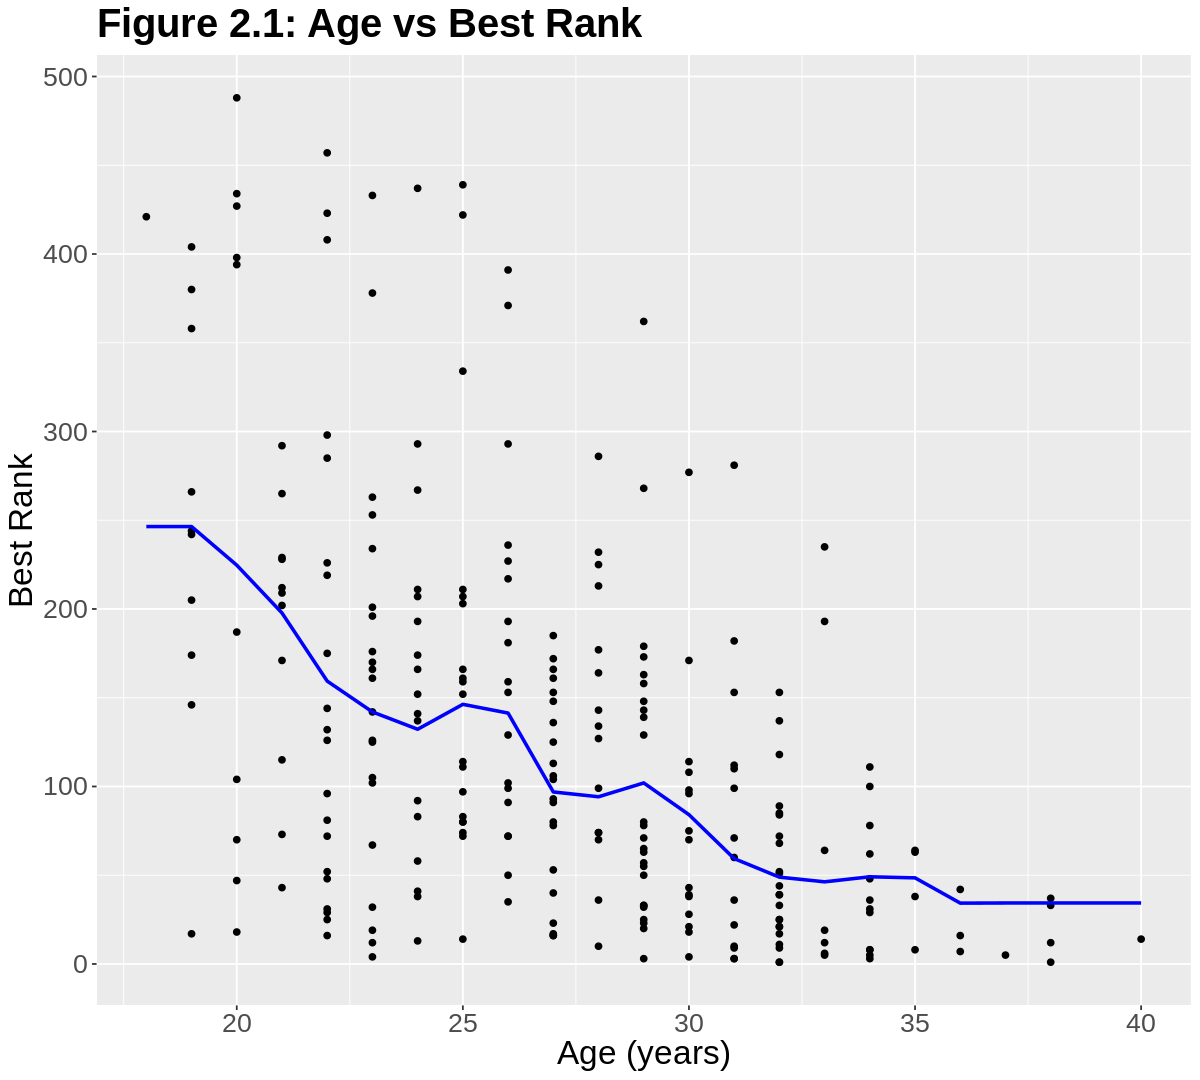

In [16]:
set.seed(4321)

options(repr.plot.width = 10, repr.plot.height = 9)
age_train_info <- tennis_data_fit_age |>
    predict(tennis_data_train) |>
    bind_cols(tennis_data_train)

age_plot <- tennis_data_train |>
    ggplot(aes(x = Age, y = Best_Rank)) +
    geom_point() +
    geom_line(data = age_train_info, mapping = aes(x = Age, y = .pred),
                color = "blue",
                size = 1) +
    labs(x = "Age (years)", y = "Best Rank", title = "Figure 2.1: Age vs Best Rank") +
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
    
    
age_plot



Next we did the same analysis for the other three predictors to determine their RMSPE.

#### Model 2: Current Rank as the only predictor

Here is the model using Current Rank:

In [17]:
set.seed(4321)


tennis_data_workflow_cr <- workflow() |>
    add_recipe(tennis_data_recipe_cr) |>
    add_model(tennis_data_specs)


cr_result <- tennis_data_workflow_cr |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

print("Tibble 1.2.9: Current Rank model results")
head(cr_result, n= 10)

kmin_cr_df <- cr_result |>
    filter(mean == min(mean))

kmin_cr <- kmin_cr_df |>
    pull(neighbors)

print("Tibble 1.2.10: Current Rank model results only displaying the lowest rmse")
kmin_cr_df
kmin_cr

[1] "Tibble 1.2.9: Current Rank model results"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,107.29032,5,7.787515,Preprocessor1_Model01
3,rmse,standard,87.63217,5,6.440203,Preprocessor1_Model02
5,rmse,standard,85.88598,5,8.356049,Preprocessor1_Model03
7,rmse,standard,81.48096,5,6.431130,Preprocessor1_Model04
9,rmse,standard,79.58673,5,5.902310,Preprocessor1_Model05
11,rmse,standard,79.05420,5,6.083453,Preprocessor1_Model06
13,rmse,standard,79.11400,5,6.488204,Preprocessor1_Model07
15,rmse,standard,78.56184,5,6.885703,Preprocessor1_Model08
17,rmse,standard,79.38126,5,7.042788,Preprocessor1_Model09


[1] "Tibble 1.2.10: Current Rank model results only displaying the lowest rmse"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
29,rmse,standard,76.68326,5,4.79879,Preprocessor1_Model15


[1] 29

Then we used k = 29 for our knn regression model and evaluated it using the testing data.

In [18]:
set.seed(4321)

tennis_data_specs_cr <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_cr) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit_cr <- workflow() |>
    add_recipe(tennis_data_recipe_cr) |>
    add_model(tennis_data_specs_cr) |>
    fit(data = tennis_data_train)

cr_pred <- tennis_data_fit_cr |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


cr_summary <- cr_pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")

cr_rmspe <- cr_summary |>
    pull(.estimate) |>
    round(digits = 0)

print("Tibble 1.2.11: RMSPE for the Current Rank model")
cr_summary
cr_rmspe

[1] "Tibble 1.2.11: RMSPE for the Current Rank model"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,71.68476


[1] 72

The RMSPE of the model with the Current Rank predictor was 72. 
Here is the visualization of the model.

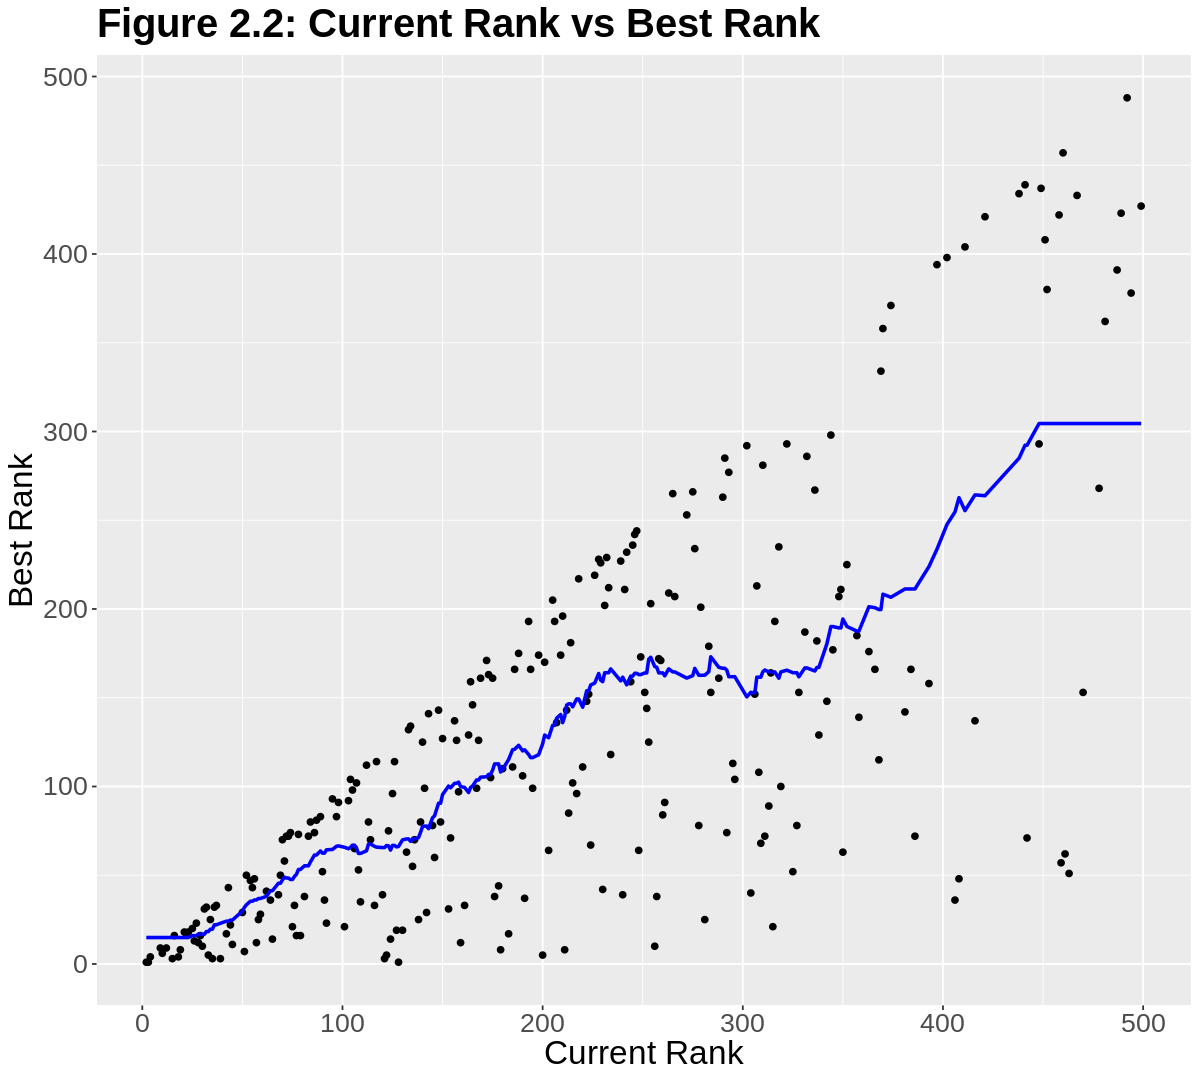

In [19]:
set.seed(4321)

cr_train_info <- tennis_data_fit_cr |>
    predict(tennis_data_train) |>
    bind_cols(tennis_data_train)


cr_plot <- tennis_data_train |>
    ggplot(aes(x = Current_Rank, y = Best_Rank)) +
    geom_point() +
    geom_line(data = cr_train_info, mapping = aes(x = Current_Rank, y = .pred),
                color = "blue",
                size = 1) +
    labs(x = "Current Rank", y = "Best Rank", title = "Figure 2.2: Current Rank vs Best Rank") +
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
    
cr_plot



#### Model 3: Prize Money as the only predictor

Here is the model using only Prize Money as the predictor.

In [20]:
set.seed(4321)


tennis_data_workflow_pm <- workflow() |>
    add_recipe(tennis_data_recipe_pm) |>
    add_model(tennis_data_specs)


pm_result <- tennis_data_workflow_pm |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

print("Tibble 1.2.12: Results for the Prize Money Model")
head(pm_result, n= 10)

kmin_pm_df <- pm_result |>
    filter(mean == min(mean))

kmin_pm <- kmin_pm_df |>
    pull(neighbors)

print("Tibble 1.2.13: Results for the Prize Money Model displaying only the lowest RMSE row")

kmin_pm_df
kmin_pm

[1] "Tibble 1.2.12: Results for the Prize Money Model"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,61.87521,5,0.9853234,Preprocessor1_Model01
3,rmse,standard,54.13094,5,1.9334194,Preprocessor1_Model02
5,rmse,standard,53.71335,5,2.1717297,Preprocessor1_Model03
7,rmse,standard,54.27701,5,1.9730118,Preprocessor1_Model04
9,rmse,standard,54.78128,5,1.9265387,Preprocessor1_Model05
11,rmse,standard,54.67015,5,1.7717932,Preprocessor1_Model06
13,rmse,standard,54.98405,5,1.7699659,Preprocessor1_Model07
15,rmse,standard,56.21815,5,1.5607669,Preprocessor1_Model08
17,rmse,standard,57.87512,5,1.4607566,Preprocessor1_Model09


[1] "Tibble 1.2.13: Results for the Prize Money Model displaying only the lowest RMSE row"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,rmse,standard,53.71335,5,2.17173,Preprocessor1_Model03


[1] 5

We used k = 5 for our knn regression model and evaluated it using the testing data.

In [21]:
set.seed(4321)

tennis_data_specs_pm <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_pm) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit_pm <- workflow() |>
    add_recipe(tennis_data_recipe_pm) |>
    add_model(tennis_data_specs_pm) |>
    fit(data = tennis_data_train)

pm_pred <- tennis_data_fit_pm |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


pm_summary <- pm_pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")


pm_rmspe <- pm_summary |>
    pull(.estimate) |>
    round(digits = 0)


print("Tibble 1.2.14: RMSPE for the Prize Money model")
pm_summary
pm_rmspe

[1] "Tibble 1.2.14: RMSPE for the Prize Money model"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,52.19929


[1] 52

The RMSPE of the model with the Prize Money predictor was 52. Here is the visualization of the model.

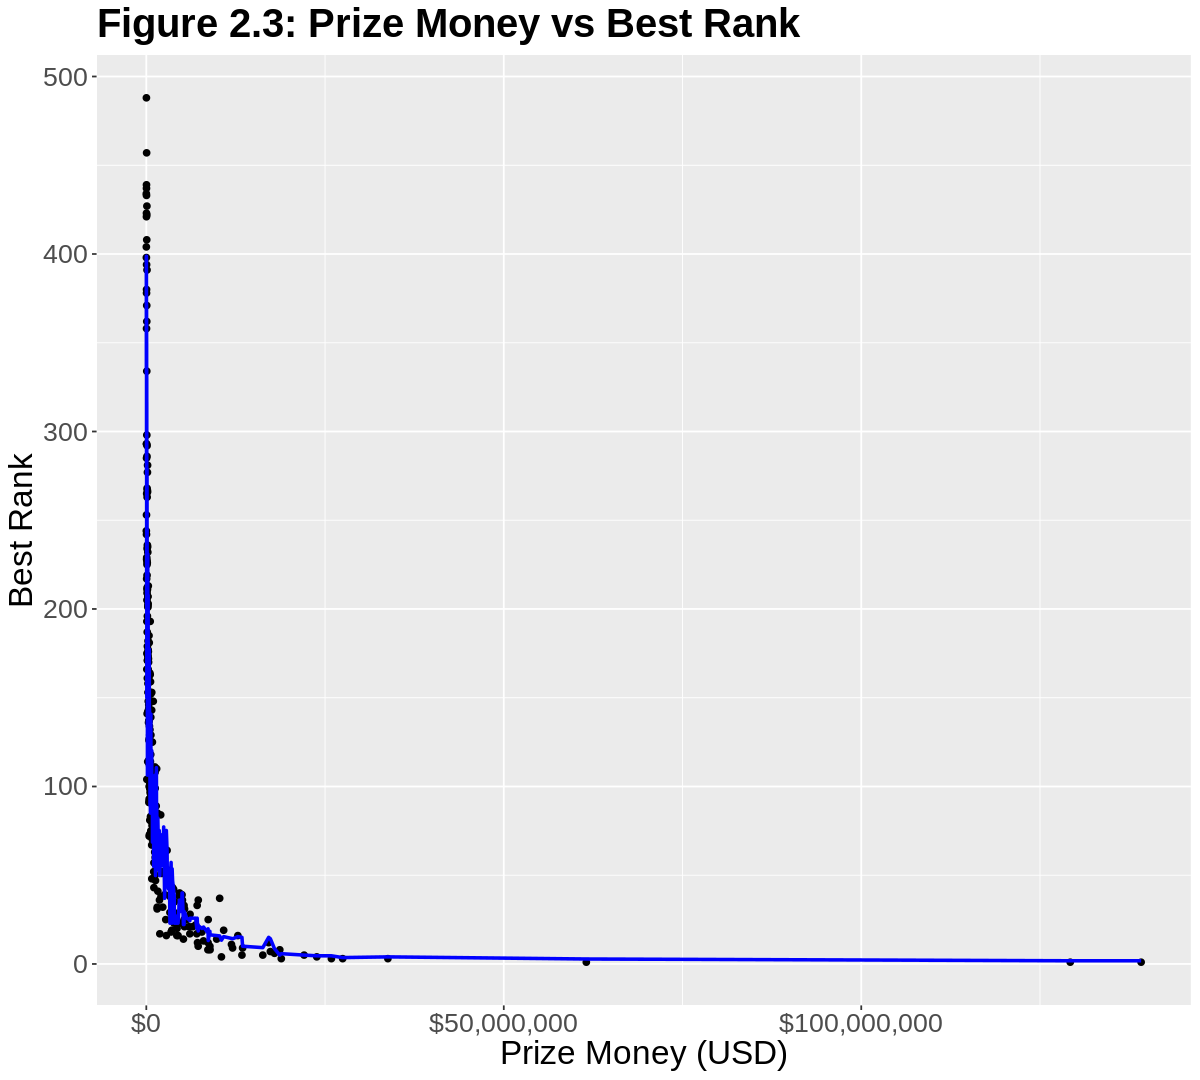

In [22]:
set.seed(4321)

pm_train_info <- tennis_data_fit_pm |>
    predict(tennis_data_train) |>
    bind_cols(tennis_data_train)

pm_plot <- tennis_data_train |>
    ggplot(aes(x = Prize_Money, y = Best_Rank)) +
    geom_point() +
    geom_line(data = pm_train_info, mapping = aes(x = Prize_Money, y = .pred),
                color = "blue",
                size = 1) +
    labs(x = "Prize Money (USD)", y = "Best Rank", title = "Figure 2.3: Prize Money vs Best Rank") +
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold")) +
    scale_x_continuous(labels = dollar_format())
    
pm_plot


#### Model 4: Seasons Played as the only predictor

Here is the model using only Seasons Played:

In [23]:
set.seed(4321)


tennis_data_workflow_seasons <- workflow() |>
    add_recipe(tennis_data_recipe_seasons) |>
    add_model(tennis_data_specs)


seasons_result <- tennis_data_workflow_seasons |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

print("Tibble 1.2.15: Results for the Seasons Played Model")
head(seasons_result, n= 10)

kmin_seasons_df <- seasons_result |>
    filter(mean == min(mean))

kmin_seasons <- kmin_seasons_df |>
    pull(neighbors)

print("Tibble 1.2.16: Results for the Seasons Played Model displaying only the lowest RMSE row")
kmin_seasons_df
kmin_seasons

[1] "Tibble 1.2.15: Results for the Seasons Played Model"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,107.16970,5,3.335835,Preprocessor1_Model01
3,rmse,standard,100.65575,5,4.381725,Preprocessor1_Model02
5,rmse,standard,96.28685,5,3.479772,Preprocessor1_Model03
7,rmse,standard,89.20247,5,3.380563,Preprocessor1_Model04
9,rmse,standard,84.50660,5,3.038438,Preprocessor1_Model05
11,rmse,standard,81.08087,5,3.472683,Preprocessor1_Model06
13,rmse,standard,77.68363,5,2.785588,Preprocessor1_Model07
15,rmse,standard,75.83417,5,2.881484,Preprocessor1_Model08
17,rmse,standard,73.93171,5,2.382876,Preprocessor1_Model09


[1] "Tibble 1.2.16: Results for the Seasons Played Model displaying only the lowest RMSE row"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
33,rmse,standard,71.86162,5,1.978071,Preprocessor1_Model17


[1] 33

Then we used k = 33 for our knn regression model and evaluated it using the testing data.

In [24]:
set.seed(4321)
tennis_data_specs_seasons <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_seasons) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit_seasons <- workflow() |>
    add_recipe(tennis_data_recipe_seasons) |>
    add_model(tennis_data_specs_seasons) |>
    fit(data = tennis_data_train)

seasons_pred <- tennis_data_fit_seasons |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


seasons_summary <- seasons_pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")

seasons_rmspe <- seasons_summary |>
        pull(.estimate) |>
    round(digits = 0)
print("Tibble 1.2.17: RMSPE for the Seasons Played model")
seasons_summary
seasons_rmspe

[1] "Tibble 1.2.17: RMSPE for the Seasons Played model"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,81.30607


[1] 81

The RMSPE of the model with the Seasons Played predictor was 81. Here is the visualization of the model.

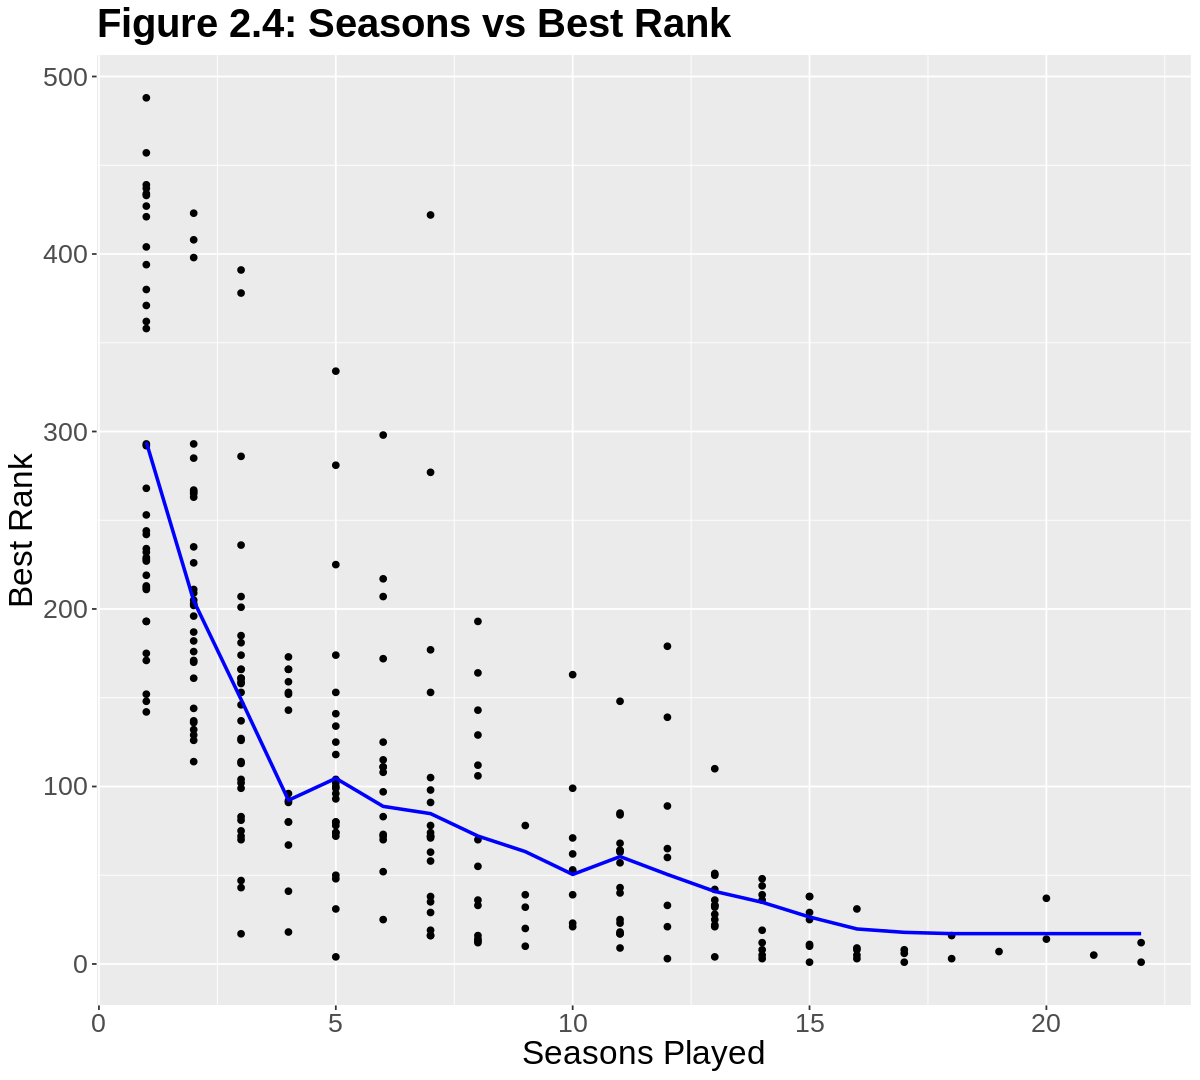

In [25]:
set.seed(4321)
seasons_train_info <- tennis_data_fit_seasons |>
    predict(tennis_data_train) |>
    bind_cols(tennis_data_train)

seasons_plot <- tennis_data_train |>
    ggplot(aes(x = Seasons, y = Best_Rank)) +
    geom_point() +
    geom_line(data = seasons_train_info, mapping = aes(x = Seasons, y = .pred),
                color = "blue",
                size = 1) +
    labs(x = "Seasons Played", y = "Best Rank", title = "Figure 2.4: Seasons vs Best Rank") +
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
    
seasons_plot

#### Model 5: Using All four Predictors 

Next we made a model which uses all the predctiors variables.

In [26]:
set.seed(4321)
tennis_data_workflow <- workflow() |>
    add_recipe(tennis_data_recipe) |>
    add_model(tennis_data_specs)


result <- tennis_data_workflow |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

print("Tibble 1.2.18: Results for the Final Model")


head(result, n= 10)

kmin_df <- result |>
    filter(mean == min(mean))

kmin_f <- kmin_df |>
    pull(neighbors)

print("Tibble 1.2.19: Results for the Final Model displaying only the lowest RMSE row")
kmin_df
kmin_f

[1] "Tibble 1.2.18: Results for the Final Model"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,53.22188,5,3.406733,Preprocessor1_Model01
3,rmse,standard,44.93832,5,3.423001,Preprocessor1_Model02
5,rmse,standard,45.94028,5,3.173076,Preprocessor1_Model03
7,rmse,standard,44.92765,5,2.961516,Preprocessor1_Model04
9,rmse,standard,44.34197,5,3.032574,Preprocessor1_Model05
11,rmse,standard,44.86720,5,3.160699,Preprocessor1_Model06
13,rmse,standard,46.28923,5,2.960859,Preprocessor1_Model07
15,rmse,standard,46.51074,5,2.834663,Preprocessor1_Model08
17,rmse,standard,46.63830,5,2.814864,Preprocessor1_Model09


[1] "Tibble 1.2.19: Results for the Final Model displaying only the lowest RMSE row"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,rmse,standard,44.34197,5,3.032574,Preprocessor1_Model05


[1] 9

Then we used k = 9 for our knn regression model and evaluated it using the testing data.

In [27]:
set.seed(4321)
tennis_data_specs_min <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_f) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit <- workflow() |>
    add_recipe(tennis_data_recipe) |>
    add_model(tennis_data_specs_min) |>
    fit(data = tennis_data_train)

pred <- tennis_data_fit |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


summary <- pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")

all_rmspe <- summary |>
    pull(.estimate) |>
    round(digits = 0)

print("Tibble 1.2.20: RMSPE for the final model")
summary
all_rmspe

[1] "Tibble 1.2.20: RMSPE for the final model"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,48.617


[1] 49

The RMSPE of the model using all 4 predictors was 49.

With our current knowledge we could not produce a visualization for the final model, simultaneously considering four quantitive factors for one predictive variable.

### Results

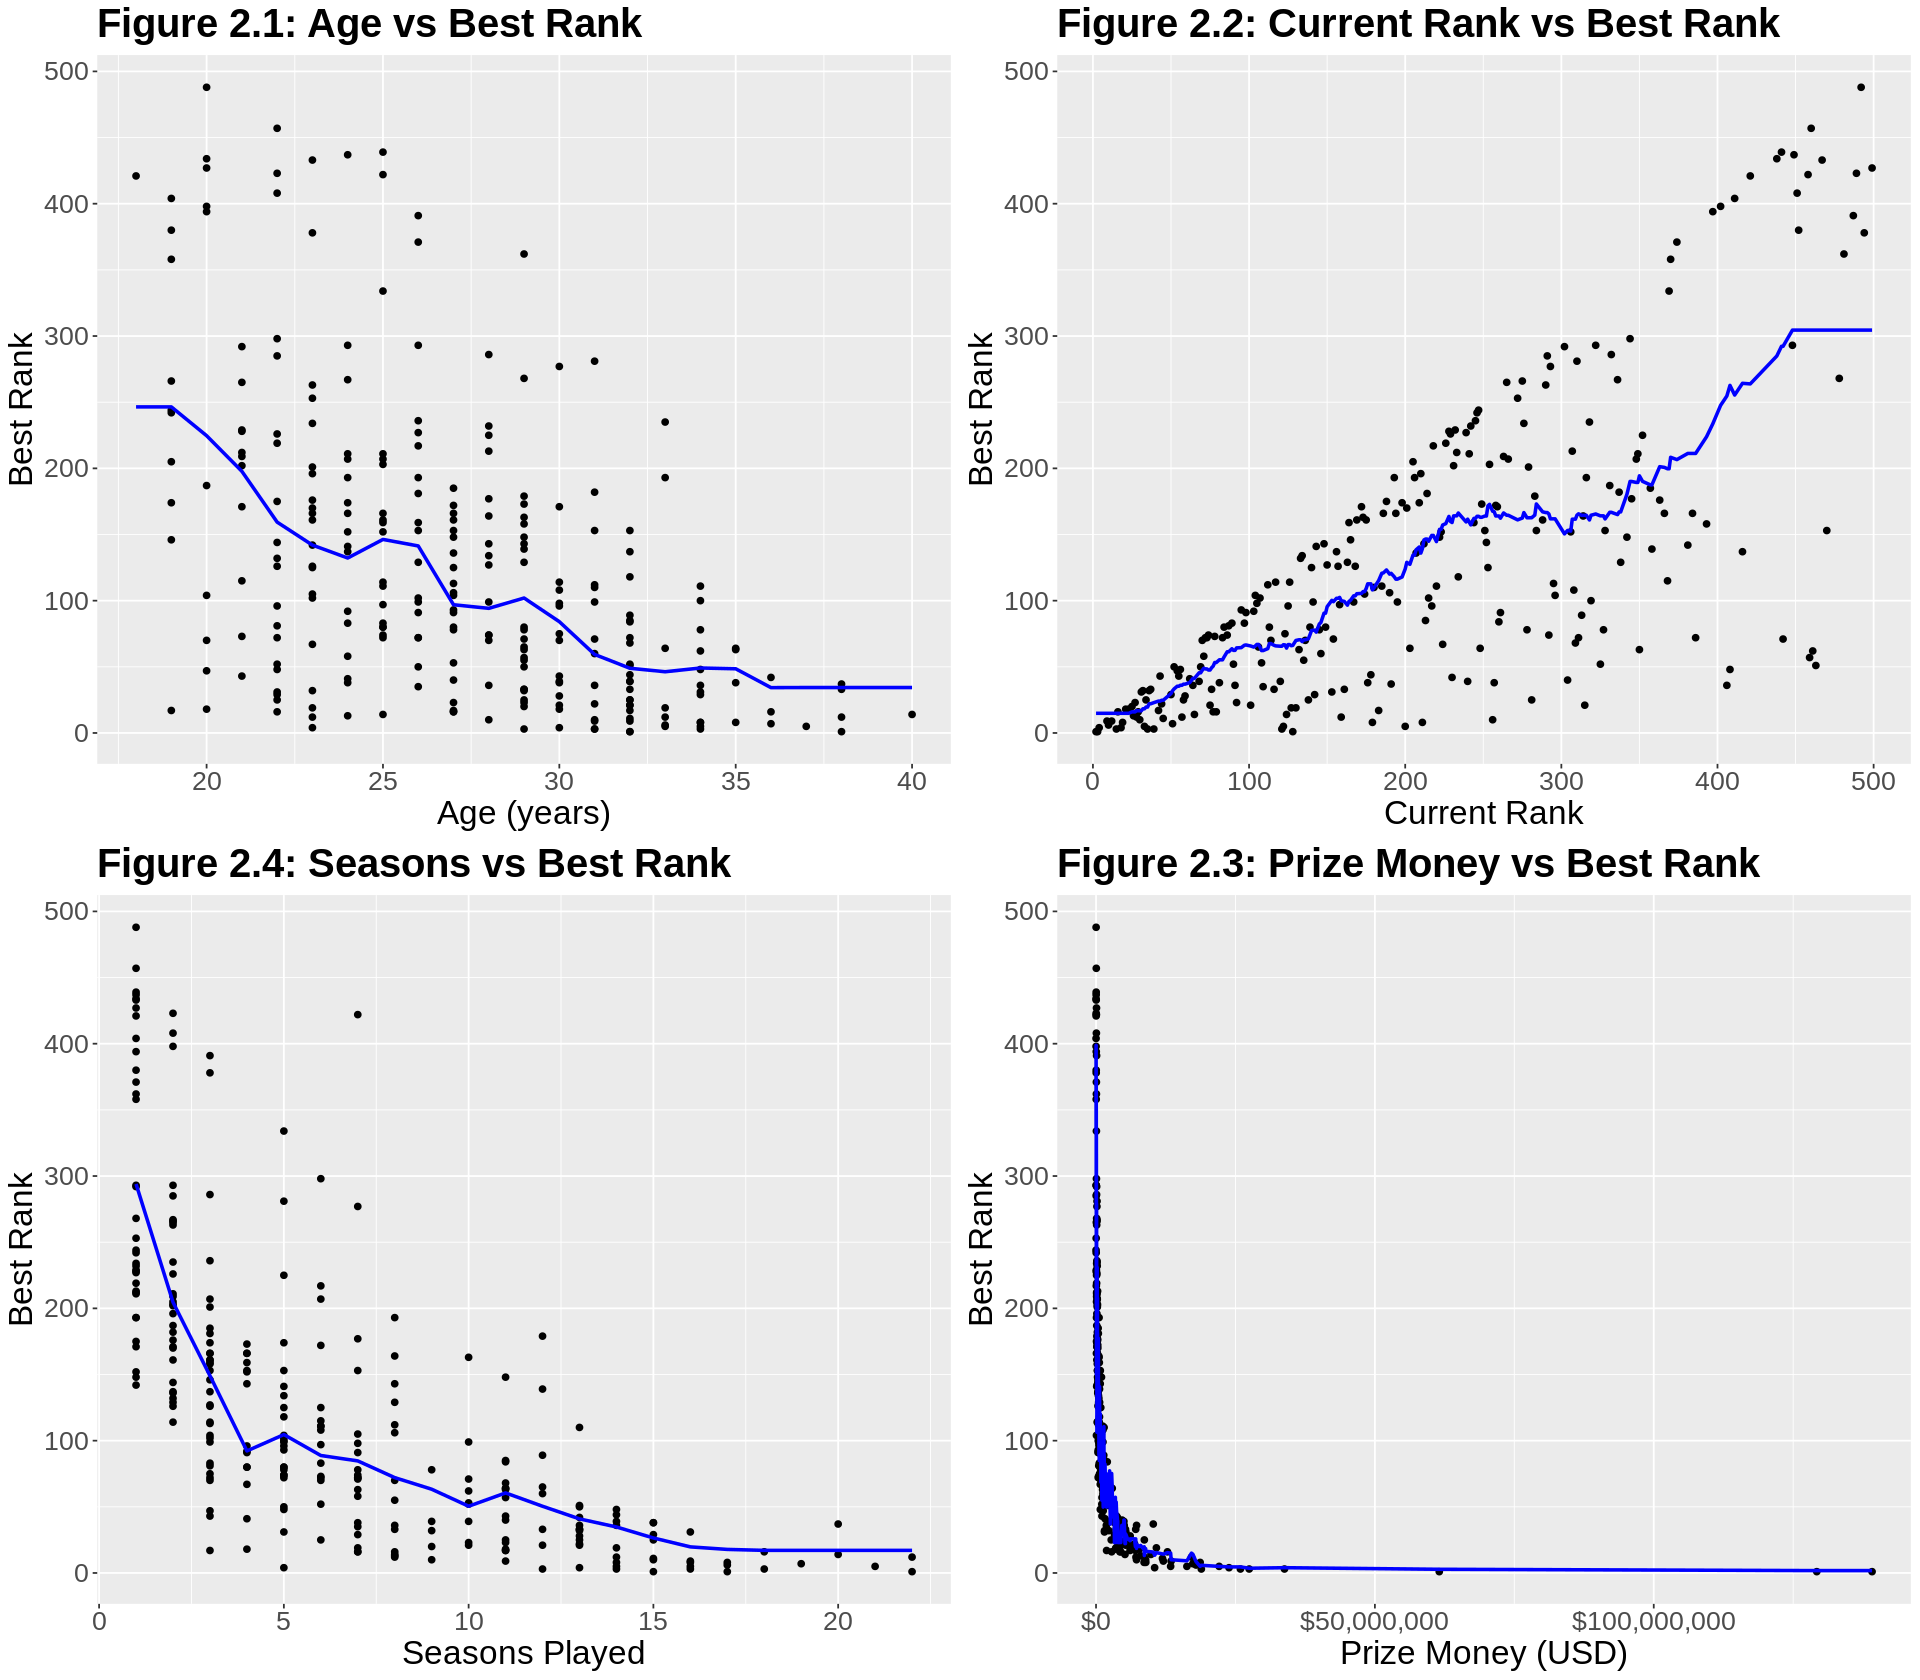

In [28]:
set.seed(4321)
options(repr.plot.width = 16, repr.plot.height = 14)

plot_grid(age_plot, cr_plot, seasons_plot, pm_plot)

               Figure 3.1: combination of all four models visualizations each with only one predictor variable.

We summarized all the RMSPE values and the k values of each model in a dataframe.

In [29]:
set.seed(4321)
RMSPE <- c (age_rmspe, cr_rmspe, pm_rmspe, seasons_rmspe, all_rmspe)

model <- c ("Age", "Current Rank", "Prize Money", "Seasons Played", "Final Model")

comparison_df <- data.frame(model, RMSPE, k_value = c(pull(kmin_age_df, neighbors), pull(kmin_cr_df, neighbors), pull(kmin_pm_df, neighbors), pull(kmin_seasons_df, neighbors) , pull(kmin_df, neighbors))) |>
    arrange(RMSPE)

print("Figure 3.2: data frame for all the 5 models, their RMSPE, and the k value each model used")
comparison_df

[1] "Figure 3.2: data frame for all the 5 models, their RMSPE, and the k value each model used"


model,RMSPE,k_value
<chr>,<dbl>,<dbl>
Final Model,49,9
Prize Money,52,5
Current Rank,72,29
Seasons Played,81,33
Age,92,25


Our comparison dataframe shows that our final model which used the recipe with all 4 predictors had the lowest RMSPE. This suggests that considering all 4 predictors provides a more accurate result than considering each of them individually. Our final model used 9 neighbors for the prediction which was higher than Prize Money (k = 5), which is likely because of the significant outliers in Prize Money, but it was lower than all other predictors k value. Using only Age as the predictor results in the highest error margin (92) which indicates that it is not as good of a predictors on its own. One the other hand, using Prize Money as the only predator results in a more accurate prediction which could be due to its stronger relationship with best rank (it can be seen in figure 2.3). The mean Best Rank was 127.7684 and the median was 99 out of 500 total ranks. Our RMSPE for the final model was 49 which shows that our model is not extremely acccurate and could be improved, but it's an acceptable margin of error.

### Discussion

Using K nearest neighbors algorithm we compared the models for predicting the best rank of a tennis player's with multiple predictors such as their Age, Current Rank, Seasons Played, and the Prize Money they have won. In order to get the most accurate model we found the optimal number of neighbors to use for each model by performing 5 fold cross validation. Then we calculated the RMSPE of each model and then compared them. As we had expected the final model with all 4 predictors gave the most accurate result when predicting best rank.

As it can be seen in figure 3.1, Age and Seasons Played both have a weak negative relationship with Best Rank. This is confirmed by our findings using the RMSPE value as the models using only Age and Seasons Played had higher values compared to the other individual predictors and our final model. Prize money and Best Rank have a strong negative exponential relationship which was also observed in our RMSPE findings, as it had a similar RMSPE value to our final model which was the most accurate. This makes sense because a player's earnings would be directly impacted by their rank. Moreover, Current Rank and Best Rank have a positive relationship. The RMSPE value for the model using Current Rank is in between the final model and the Age model which indicates that this predictor alone would also not be the most accurate. The RMSPE value for the final model (49) although acceptable, was higher than expected, which could be due to the absence of better predictors; if this were the case, the model could be improved by considering more/alternate predictors such as player's injury history. 

These findings provide insights into the relative importance of different predictors in determining a tennis player's Best Rank. The results suggest that considering all four predictors together provides a more accurate prediction compared to using them individually. Although Prize Money and Best Rank have a stron relationship, alone it does not prove to be a good predictor because Best Rank is not determined by the Prize Money, Prize Money is determined by the rank.

The findings are also useful for players, coaches and recruiters to plan and predict a player's future potential based on their current standing in the league. For players, it brings valuable insights as it would help them understand where they are in their career and motivate them to aim for higher ranks. Because Prize Money increases exponentially as rank increases (gets closer to zero) as it can be seen in figure 2.3, this model can help them understand their potential career earnings.

Overall, these findings provide potential opportunities for a continuation of research in to predicting ranks for both tennis players and other athletes. It can also contribute to a more meaningful and better understanding what factors impact a player's career and rank and provide a better understanding of the dynamics of single player sports.


Our findings give rise to other questions such as:
 * What other predictors apart from age, seasons played, current rank, and prize money could impact a tennis player's best rank?
    
 * Can other algorithms provide a better accuracy in predicting a tennis player's best rank compared to K nearest neighbors regression?
    
 * Is this model applicable to other individual player sports such as golf?
    
 * How could external factors such as rule modifications or tournament schedules impact the accuracy of this predictive model?
 * What combination of predictors would produce the smallest margin of error/RMSPE?
 * Would the model for predicting best rank differ between men's and women's tennis?
    

### References

Timbers, T.-A., Campbell, T., &amp; Lee, M. (2022). Data science: A first introduction. CRC Press, Taylor &amp; Francis Group. 

Ultimate Tennis Statistics. (2020). Retrieved April 12, 2023, from https://www.ultimatetennisstatistics.com/ 